In [143]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
%matplotlib inline
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = 18 #fig_width_pt*inches_per_pt  # width in inches
fig_height = 8 # fig_width*golden_mean*2      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 20,
          'font.size': 16,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)

# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
# Plot typical data from the precipitation model:
# time x out_lat,   1 plot per in_lat
# (For AGU 2016 poster)

from precip_model import precip_model

p = precip_model(database="db_agu2016_kp0_full.pkl", cumsum=False)

in_lats = [50, 40, 30, 20]
out_lats = np.arange(30, 60, step=0.1)
# out_lons = np.arange(,3, step=2)
out_lons = [1]
lon_plotind = 0

num_inlats = len(in_lats)
t = p.t

interp_d = p.get_multiple_precip_at(in_lats, out_lats, out_lons, t)

(4, 300, 1, 2000)


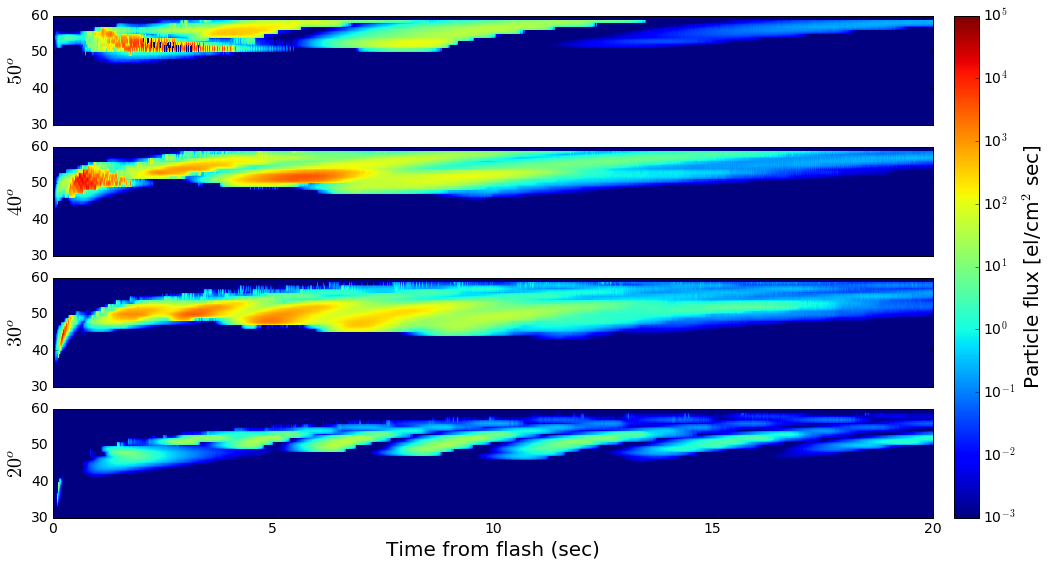

In [248]:
clims = [-3,5]

print np.shape(interp_d)

# fig, ax = plt.subplots(len(in_lats),1)

fig = plt.figure()

ax=[]
for i,lat in enumerate(in_lats):
    ax.append(fig.add_subplot(num_inlats,1,i+1))
    #Nv = np.log10(interp_d[i,:,2:] - interp_d[i,:,0:-2])
    Nv = np.log10(np.maximum(0,interp_d[i,:,lon_plotind,:]))
    Nv = np.clip(Nv,clims[0],clims[1])
    
    p1 = plt.pcolormesh(t, out_lats, Nv)
    ax[i].set_xticks([])
    ax[i].set_yticks([30, 40, 50, 60])
    ax[i].set_ylabel('$%d^o$'%lat)
    plt.clim(clims)

ax[-1].set_xticks(np.arange(0, t[-1]+1,step=5))
ax[-1].set_xlabel('Time from flash (sec)')

cb = plt.colorbar(p1, ax=ax, pad=0.02)
ctix = np.arange(clims[0], clims[1] + 1, step=1)
cb.set_ticks(ctix)
cb.set_ticklabels(['10$^{%d}$'%k for k in ctix])
cb.set_label('Particle flux [el/cm$^2$ sec]')


    


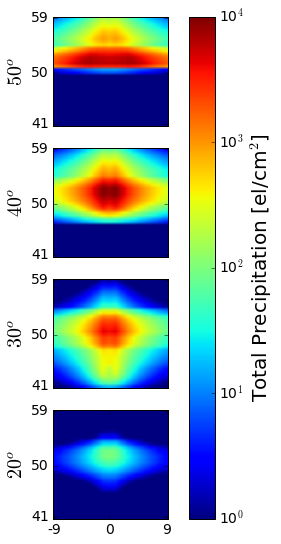

In [250]:
# hot-spot maps:
p = precip_model(database="db_agu2016_kp0_full.pkl", cumsum=False)

in_lats = [50, 40, 30, 20]
dl = 9
lat0 = 50
# out_lats = np.arange(30,60,step=0.5)

# lat0 = out_lats[peak_inds[0][0]]
out_lats = np.arange(lat0 - dl, lat0 + dl, step=.5)
out_lons = np.arange(-dl, dl +1, step=.5)

clims=[0,4]

num_inlats = len(in_lats)
t = p.t

interp_d = p.get_multiple_precip_at(in_lats, out_lats, out_lons, t)

totes = np.sum(np.maximum(0, interp_d), axis=3)*(p.sc.T_STEP)
# fig, ax = plt.subplots(1,1)

Tv = np.log10(np.maximum(0,totes))
Tv = np.clip(Tv, clims[0],clims[1])
Tv[np.isnan(Tv)] = clims[0]
fig = plt.figure()
ax=[]
for i,ilat in enumerate(in_lats):
    ax.append(fig.add_subplot(num_inlats,1,i+1))
    
    
#    ax[i].pcolormesh(out_lons, out_lats, Tv[0,:,:])
    p1 = ax[i].imshow(Tv[i,:,:], origin='lower',aspect='auto')
    ax[i].set_aspect('equal')

    p1.set_clim(clims)
#     find center coords:
#     peak_inds = np.where(totes[i,:,:]==np.max(totes[i,:,:]))
    

    ax[i].set_yticks([0, (len(out_lats)/2.) - 1, len(out_lats) -1 ])
    ax[i].set_yticklabels([lat0 - dl, lat0, lat0 + dl])
    ax[i].set_xticks([])
    ax[i].set_ylabel('$%d^o$'%ilat)


ax[-1].set_xticks([0, (len(out_lons)/2.) - 1, len(out_lons) -1 ])
ax[-1].set_xticklabels([-dl, 0, dl])

cb = plt.colorbar(p1, ax=ax, pad=0.02)
ctix = np.arange(clims[0], clims[1] + 1, step=1)
cb.set_ticks(ctix)
cb.set_ticklabels(['10$^{%d}$'%k for k in ctix])
cb.set_label('Total Precipitation [el/cm$^2$]')



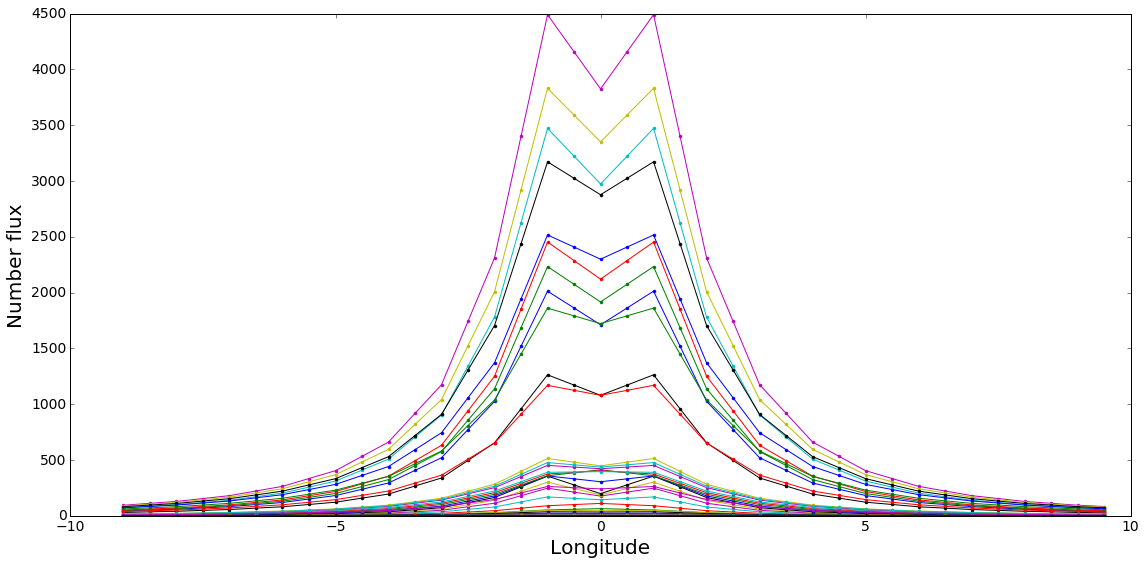

In [310]:
plt.figure()
plt.plot(out_lons, totes[2,:,:].T,'.-');
plt.xlabel('Longitude')
plt.ylabel('Number flux')

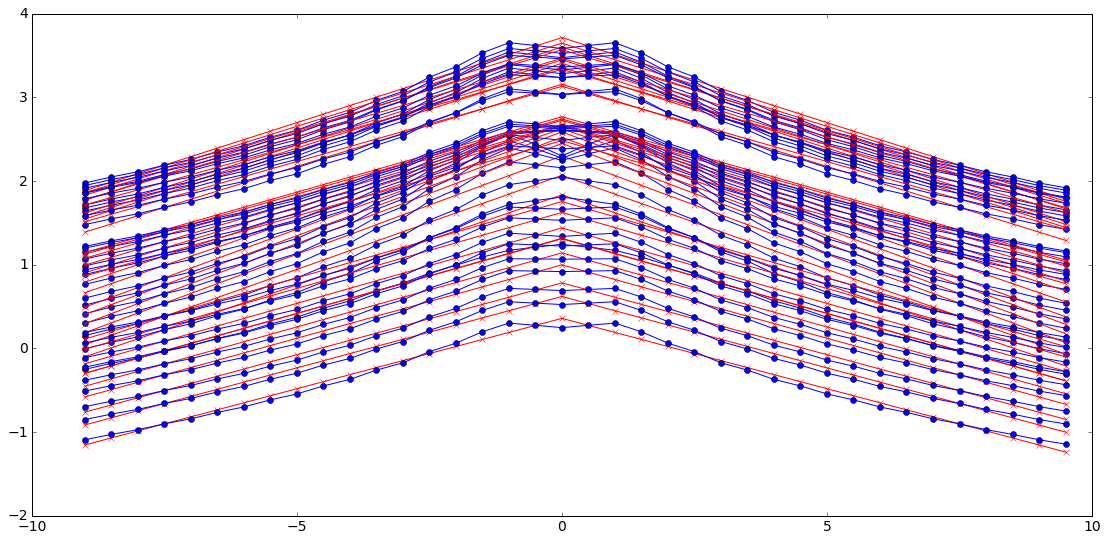

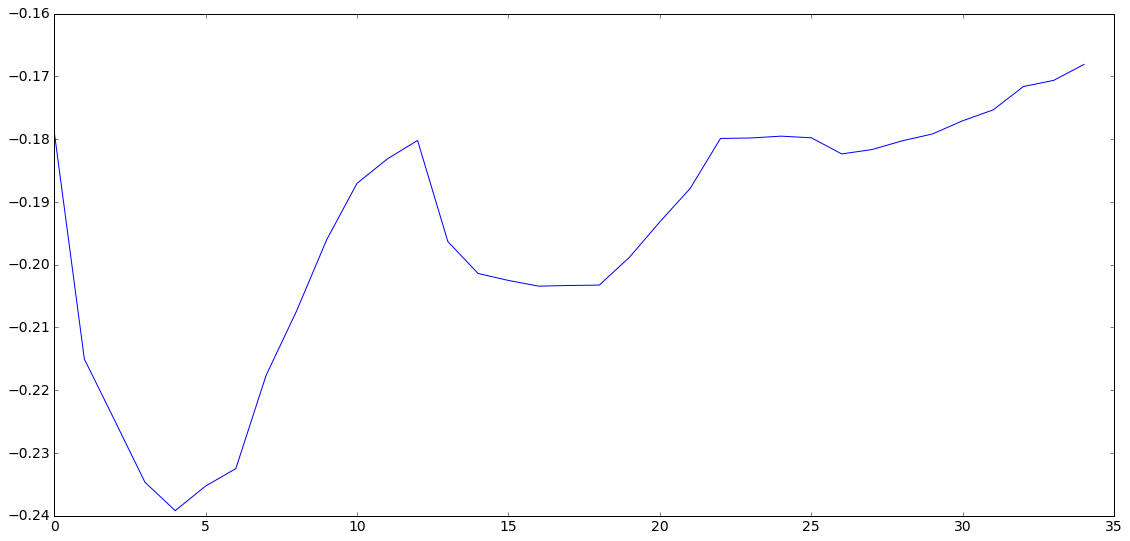

In [373]:
from scipy.optimize import curve_fit
from __future__ import division

# Gaussian curve model
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def Laplace(x, a, b, x0):
    return a*np.exp(-np.abs(x - x0)/b)

def abslinear(x, m, b):
    return m*np.abs(x) + b

# from scipy import asarray as ar,exp
fitvals = []
plt.figure()
for zz in np.arange(0,35):
    x = out_lons
    y = np.log10(np.maximum(0.0001,(totes[2,zz,:])))


#     n = len(x)
#     mean = sum(x * y) / sum(y)
#     sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))



    # popt,pcov = curve_fit(gaus,x,y,p0=[0.1,mean,sigma])
#     popt,pcov = curve_fit(Expn,x,y,p0=[np.max(y), 1,0])
    popt,pcov = curve_fit(abslinear, x, y, p0=[1,0])
    fitvals.append(popt)
#     print popt
#     plt.figure()
#     plt.plot(x,y,'b+:',label='data')
#     plt.plot(x,Expn(x,*popt),'ro:',label='fit')
    plt.plot(x, abslinear(x, *popt),'rx-')
    plt.plot(x,y, 'bo-')
fitvals = np.asarray(fitvals)
plt.figure(2)
plt.plot(fitvals[:,0])

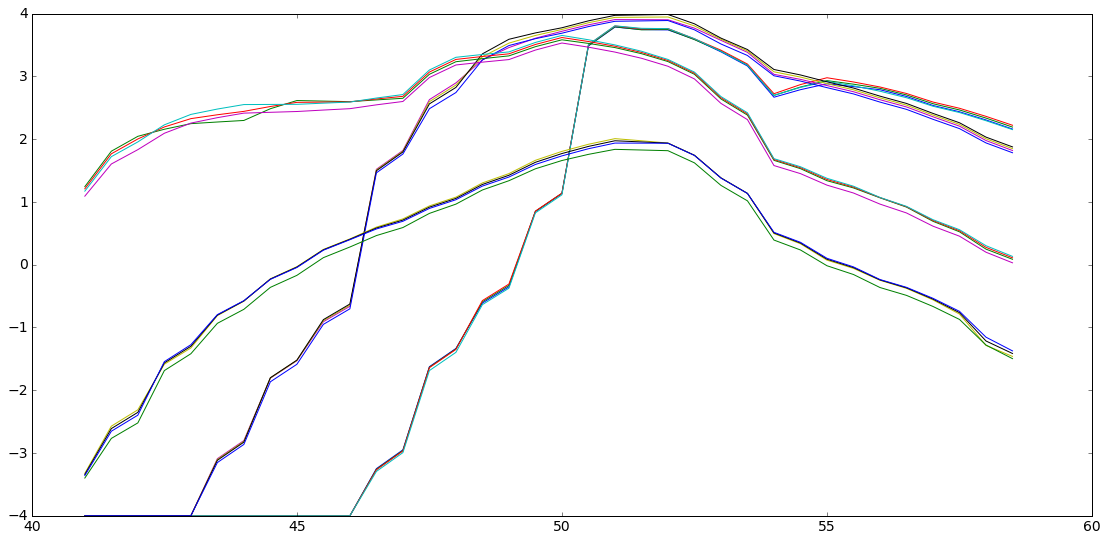

In [382]:
from scipy.optimize import curve_fit
from __future__ import division

# Gaussian curve model
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def Laplace(x, a, b, x0):
    return a*np.exp(-np.abs(x - x0)/b)

def abslinear(x, m, b):
    return m*np.abs(x) + b

# from scipy import asarray as ar,exp
fitvals = []
plt.figure()
for i, iLat in enumerate(in_lats):
    for zz in np.arange(18,22):
        x = out_lats
        y = np.log10(np.maximum(0.0001,(totes[i,:,zz])))


        popt,pcov = curve_fit(abslinear, x, y, p0=[1,0])
        fitvals.append(popt)
    #     print popt
    #     plt.figure()
    #     plt.plot(x,y,'b+:',label='data')

    #     plt.plot(x, abslinear(x, *popt),'rx-')
        plt.plot(x,y)
    # fitvals = np.asarray(fitvals)
    # plt.figure(2)
    # plt.plot(fitvals[:,0])

(36, 38) (36, 38) (36, 38)


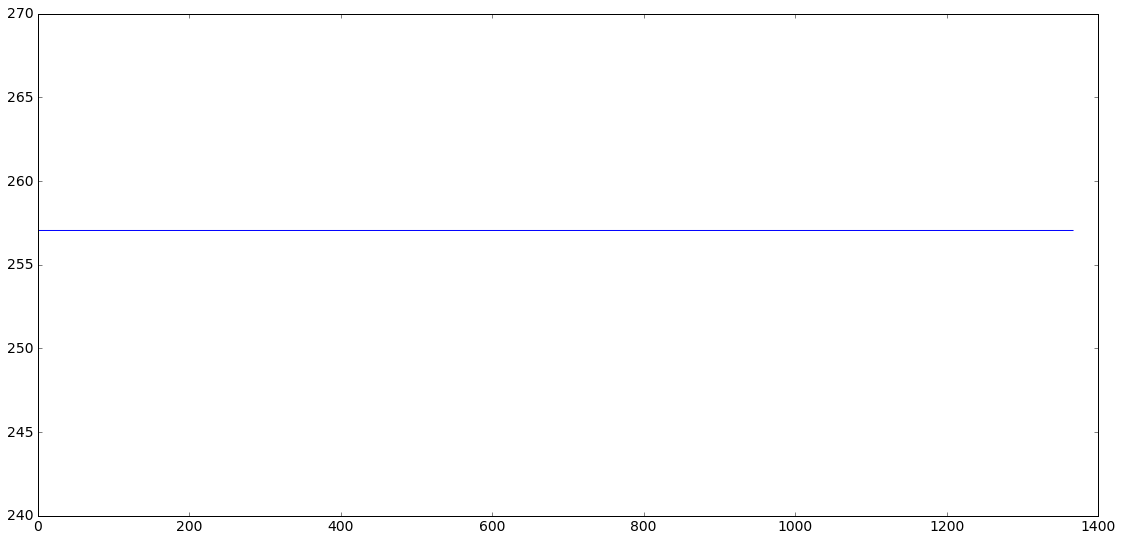

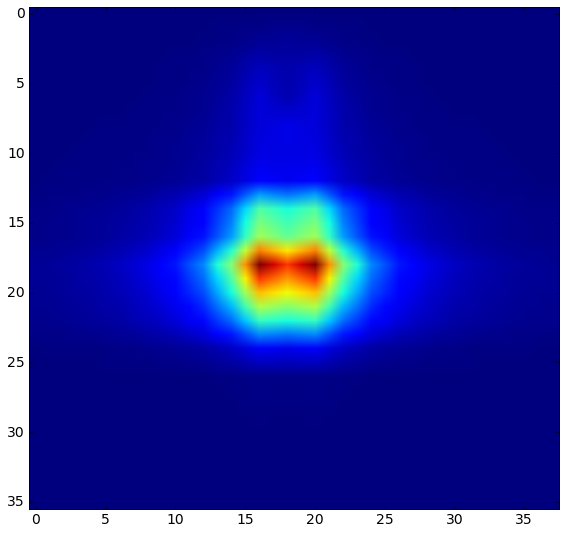

In [349]:

def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()



x, y = np.meshgrid(out_lons, out_lats)
data = totes[2,:,:]

print np.shape(x), np.shape(y), np.shape(data)


# add some noise to the data and try to fit the data generated beforehand
initial_guess = (3,100,100,20,40,0,10)

# data_noisy = data + 0.2*np.random.normal(size=data.shape)

popt, pcov = curve_fit(twoD_Gaussian, (x, y), data.ravel(), p0=initial_guess)

data_fitted = twoD_Gaussian((x, y), *popt)

plt.plot(data_fitted)
fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.imshow(data)
# ax.contour(x, y, data_fitted.reshape(np.shape(x)), 8, colors='w')
# plt.show()






